# Quantum hello world

In this notebook we explore how to run quantum programs on IBM runtime service.
See: https://docs.quantum.ibm.com/start/hello-world

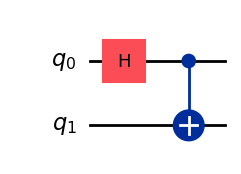

In [26]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
# store api token in credentials.py 
# the token can be found from your IBM account
import credentials

# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# The circuit can be printed or drawn with either Matplotlib or latex
qc.draw("mpl")

     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


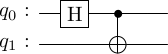

In [27]:
# Other visualization options
print(qc.draw())
print(qc)
qc.draw("latex")

In [28]:
# Set up six different observables.
# Here ZZ refers to measuring the Z operator on both qubits
observables_labels = ["ZZ", "ZI", "IZ", "XX", "XI"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [29]:
# Construct the Estimator instance we want to use.
 
# To run on IBM we use the QiskitRuntimeService
# Remember to pass you api token

# service = QiskitRuntimeService(channel="ibm_quantum", token=credentials.token)
 
# Run on the least-busy backend you have access to
# backend = service.least_busy(simulator=False, operational=True)
 
# Use the following code instead if you want to run on a simulator:
from qiskit_ibm_runtime.fake_provider import FakeCairoV2
backend = FakeCairoV2()
 
estimator = Estimator(backend)

# Resilience level refers to the error mitigation method used
# see https://docs.quantum.ibm.com/run/configure-error-mitigation

estimator.options.resilience_level = 1
estimator.options.default_shots = 5000 # how many times the circuit is run
 
# Convert to an ISA (instruction set architecture) circuit and layout-mapped observables.
# See https://docs.quantum.ibm.com/run/configure-runtime-compilation for optimization level
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, observables)])
 
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

/home/oskari/presentations/Quantum Computing Hands On/qiskit-demo/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 5000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [30]:
print(pub_result.data)

DataBin<5>(evs=[0.93896484 0.01220703 0.01074219 0.93261719 0.02587891], stds=[0.0053752  0.01562384 0.0156241  0.00563855 0.01561977])


<ErrorbarContainer object of 3 artists>

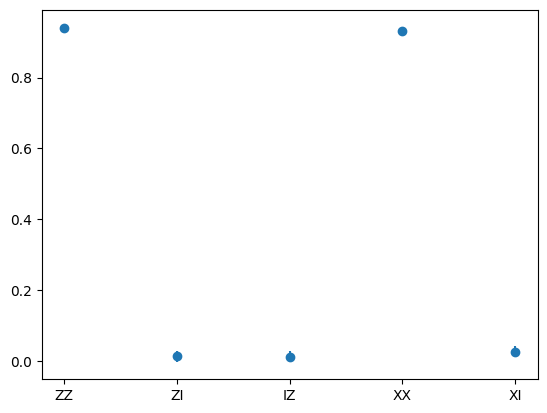

In [31]:
# Plot the result
 
from matplotlib import pyplot as plt
 
data = observables_labels
values = pub_result.data.evs
 
# errors = pub_result.data.ensemble_standard_error
errors = pub_result.data.stds
 
plt.errorbar(observables_labels, values, yerr=errors, fmt="o")